In [1]:
import networkx as nx
import pandas as pd
from typing import List, Dict, Tuple
import scipy as sp
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


## Data gathering and cleaning

Procedures to gather and clean data. Data is gathered from https://networks.skewed.de/net/fao_trade and here below there is a script to download and extract the data (directly from the source, in a CSV format). 

After the data is gahered, it will be saved in a `data/fao_trade` folder (there will be created 3 CSV files). Here below there are also some procedures to read those CSVs, clean the data and create the graph(s).

If you wish to avoid to re-download the data, set the Python variable `download_data = False` (see code box below).

### Data gathering

In [2]:
# target folder: where the data will be saved
target = "data/fao_trade"

# set it to True if you want to download the data
# download_data = True
download_data = False


In [3]:
if download_data:

    # data url source
    url = "https://networks.skewed.de/net/fao_trade/files/fao_trade.csv.zip"

    import urllib.request
    import zipfile
    import os

    # Create the data directory
    if not os.path.exists("data"):
        print("Creating data directory...")
        os.mkdir("data")

    # Download the data, unzip it and save it locally 
    print(f"Dowloading data from {url}...")
    f, _ = urllib.request.urlretrieve(url)
    print("Dowload OK!")

    with zipfile.ZipFile(f, 'r') as zip_ref:
        print("Extracting zip file...")
        zip_ref.extractall(target)
        print("Zip extraction OK!")

    print(f"Operation completed! Your CSV data is available at {target}")
     

### Data extraction and cleaning

Our data is made by 3 CSV files, that can be extracted into two `pandas.DataFrame` and one key-value `dict`.

1. `nodes` contains the list of countries and their attributes. Their only relevant attribute found in this dataset is the `name` of the country. The country name will be used as the node label.

2. `edges` contains all the weighted directed edges between countries(`source` and `target`). Each edge is labeled with the `layer` of the trade, that thanks to `gprops.layer_key` could be associated to a specific commodity. The weight of the edge is the value of the trade. 

    Before going on, we replace all the numerical indexes with testual values (both for countries and commodities).

3. `gprops` is a key-value which contains various meta-data, including the mapping between the `layer` and the commodity name.

NOTE: you may observe that our data does not describe a simple graph, but a multi-graph (a pair of nodes may have more than two directed edge between them). This is due to the fact that this dataset describes the trade of more than one commodity. We will see later how to deal with this.

Now we extract the data from CSV files, we clean it and then we will plot the head of the two `pandas.DataFrame` `nodes` and `edges`.

In [4]:
# --------------------------------------------------
# Extract nodes (as dataframe)

nodes = pd.read_csv(target + "/nodes.csv")
nodes.columns = nodes.columns.str.replace(" ", "")
nodes.columns = nodes.columns.str.replace("#", "")
nodes = nodes.set_index("index")

# drop redundant data
nodes = nodes.drop(["nodeLabel", "_pos"], axis="columns",)

# --------------------------------------------------
# Extract edges (as dataframe)

edges = pd.read_csv(target + "/edges.csv")
edges.columns = edges.columns.str.replace(" ", "")
edges.columns = edges.columns.str.replace("#", "")

# --------------------------------------------------
# Extract various graph properties (as dict)

gprops_df = pd.read_csv(target + "/gprops.csv", on_bad_lines='skip')
gprops_df.columns = gprops_df.columns.str.replace(" ", "")
gprops_df.columns = gprops_df.columns.str.replace("#", "")

# make a dict object out of the gprops dataframe
gprops = gprops_df.set_index("prop_name").to_dict()["value"]

# extract the layers keys (as a dict)
layer_keys = {}
for item in gprops["layer_key"] \
    .replace(" ", "").replace("\n", "") \
    .replace("{", "").replace("}", "") \
    .split("',"):

    keyvalue = item.split(":'")
    layer_keys[int(keyvalue[0])] = keyvalue[1]

gprops["layer_key"] = layer_keys

del layer_keys, gprops_df

# --------------------------------------------------
# replace numeric index with textual names

# replace country indexes in edges
edges["source"] = edges["source"].map(nodes["name"])
edges["target"] = edges["target"].map(nodes["name"])

# replace commodity indexes in edges
edges["layer"] = edges["layer"].map(gprops["layer_key"])

# set country name as node index
nodes = nodes.set_index("name")

In [5]:
nodes.head()

""
name
Afghanistan
Australia
Austria
Belgium
Brazil


In [6]:
edges.head()

,source,target,weight,layer
0,Afghanistan,Australia,6,Food_prep_nes
1,Afghanistan,France,14,Food_prep_nes
2,Afghanistan,Pakistan,1,Food_prep_nes
3,Afghanistan,United_Kingdom,13,Food_prep_nes
4,Afghanistan,United_States_of_America,3,Food_prep_nes


In [7]:
# show that there is more than one layer
edges[
    edges["source"].isin(['Afghanistan']) &
    edges["target"].isin(['Australia'])
]

,source,target,weight,layer
0,Afghanistan,Australia,6,Food_prep_nes
18,Afghanistan,Australia,1,"Flour,_wheat"
27,Afghanistan,Australia,8,Crude_materials
47,Afghanistan,Australia,8,"Fruit,_prepared_nes"
141,Afghanistan,Australia,2,"Nuts,_prepared_(exc._groundnuts)"
185,Afghanistan,Australia,3,Sugar_confectionery
211,Afghanistan,Australia,33,Raisins


In [8]:
# number of layers
len(edges["layer"].unique())

364

## Graph building

Here, in this section, we will build the graph from the data extracted in the previous section. We will also propose some solutions to deal the multi-layer problem.

### Deal the multi-layer problem

We propose three approaches to deal with the multi-layer problem:

1. First approach is a naive "filter and merge". If we are interested in analizing how the global trade works for some commodities, we can simply
   1. select only the edges that are related to the commodities we are interested in
   2. aggregate them by summing the weights of the edges between the same pair of nodes

    This way we obtain an unique aggregated directed and weighted graph, where each pair of nodes has at most two directed edges between them (one for each direction).

    If we are interested in analizing how the global trade works for all the commodities, we can simply keep all the edges and aggregate them.

2. Second approach is to build more graphs and then compare them. This approach may be useful if we want to compare differet commodities trades. Comparison may be done:
   1. comparing (normalized) topological and centrality indexes (also consiedering distribution)
   2. comparing different meso-scale structures with correlation indexes
   3. making visual comparison between matrixes plots

    We can also combine this approach with the first one to compare several "subsets" of the global trade.

3. Third approach is more peculiar. As discussed in https://www.nature.com/articles/ncomms7864, in a multi-layer graph, some layers are more similar or dissimilar than others; for this reason, aggregating dissimilar layer may introduce artificial structures that may be misleading. For this reason the article proposes an information theory based method to aggregate several layers withouth loosing too much information. Briefly, the article implement a sort of hierarchical clustering on the layers, where at each step you aggregate layers with similar import-export paths.

    This approach permits to obtain a smaller subset of relevant aggregated layers, that can be used to build a smaller number or comparable graphs.

In this notebook we will implement the first approach on the whole dataset. Then we will select some sample layers to make some comparisons. The third approach will not be used now because of its computational complexity.

### Build layers graphs

We start building a graph foreach layer. Then we also implement a function to merge graphs.

In [9]:
# extract the layers graphs 
def create_layers_graphs(edges: pd.DataFrame) -> Dict[str, nx.DiGraph]:
    """
    Create a dict of all graphs, one for each layer
    """

    layers_m = {}
    for layer in edges["layer"].unique():
        layers_m[layer] = nx.from_pandas_edgelist(
            edges[edges["layer"] == layer],
            source="source",
            target="target",
            edge_attr="weight",
            create_using=nx.DiGraph
        )
    return layers_m

layers_g = create_layers_graphs(edges)

In [10]:
def merge_weighted_graphs(G, H):
    """
    Merge two weighted graphs summing the weights of the edges in common.
    """

    g = nx.compose(G, H)
    edge_data = { e: G.edges[e]['weight'] + H.edges[e]['weight'] for e in G.edges & H.edges }
    nx.set_edge_attributes(g, edge_data, 'weight')
    return g

# merge all layers into a single graph
layers_names = list(layers_g.keys())
all_layers_g = layers_g[layers_names[0]]
for layer in layers_names[1:]:
    all_layers_g = merge_weighted_graphs(all_layers_g, layers_g[layer])


## Analysis on the whole dataset graph

Now we perform an analysis on the whole dataset graph (the one where all the layers are aggregated). 

This analaysis includes:
- an overview of the graph, with some simple topological indexes
- a calculation of some centrality indexes, an analysis of their distribution and a comparison between them
- ...

### Graph overview

With what kind of graph are we dealing with? Is it dense or is it sparse? Is it (strongly/weakly) connected?

In [11]:
# general graph properties
topological = {}

topological["n"] = len(all_layers_g.nodes)
topological["m"] = len(all_layers_g.edges)
topological["tot_weight"] = sum([all_layers_g.edges[e]['weight'] for e in all_layers_g.edges])
topological["density"] = topological["m"]/topological["n"]*(topological["n"]-1)

print(f"Nr. of nodes (Size): {topological['n']}")
print(f"Nr. of directed edges (Volume): {topological['m']}")
print(f"Total weight of directed edges: {topological['tot_weight']}")
print(f"Density: {round(topological['density'], 4)}")


Nr. of nodes (Size): 214
Nr. of directed edges (Volume): 13736
Total weight of directed edges: 1109494817
Density: 13671.8131


In [12]:
# Check if graph is connected
topological["weakly_connected"] = nx.is_weakly_connected(all_layers_g)
topological["strongly_connected"] = nx.is_strongly_connected(all_layers_g)

print("Weakly connected: ", topological["weakly_connected"])
print("Strongly connected: ", topological["strongly_connected"])

Weakly connected:  True
Strongly connected:  False


In [13]:
# Find SCC and their sizes 
scc = nx.strongly_connected_components(all_layers_g)

scc_sizes = [len(c) for c in sorted(scc, key=len, reverse=True)]

unique, counts = np.unique(scc_sizes, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Nr. of SCC with {u} nodes: {c}")


print(f"{scc_sizes[0]}/{topological['n']} ({round(scc_sizes[0]/topological['n'], 2)*100}%) nodes are in the largest SCC")

Nr. of SCC with 1 nodes: 81
Nr. of SCC with 133 nodes: 1
133/214 (62.0%) nodes are in the largest SCC


### Centrality indexes (pt. 1 - Friedman centralities) 

Which are the main nodes of the graph? Which are the main countries in the global trade (according to various measures)? What is the distribution of the centrality indexes? Is there any correlation between them? Which topological features may we derive from the centrality indexes?

In [14]:
# init a dataframe where I store all the centralities
centralities = pd.DataFrame(index=all_layers_g.nodes)

In [15]:
# degree centrality
centralities["in_degree"] = dict(all_layers_g.in_degree)
centralities["out_degree"] = dict(all_layers_g.out_degree)

# streght centrality (weighted degree)
centralities["in_strength"] = dict(all_layers_g.in_degree(weight='weight'))
centralities["out_strength"] = dict(all_layers_g.out_degree(weight='weight'))

# calculate difference between in and out strength
centralities["out - in"] = centralities["out_strength"] - centralities["in_strength"]

Observation on meaning of degree-based indexes and strength: 

> In this network, degree-based indexes may measure "how broad are the trade relations of a country", while strength-based indexes may measure the total volume of trades. We also propose to use `out_strength - in_strength` to measure the difference between the volume of exports and imports.

In [16]:
# Calculate all the distances between nodes (ignoring weights)
dist = nx.floyd_warshall(all_layers_g, weight=None)

Observation on meaning of distance-based indexes: 

> In this network a weighted shortest path has little meaning, because the path with lowest weight is the path with less volume, and that doesn't seem so meaninful. Instead, we can still use the unweighted shortest paths as a measure of "how far are two countries in the global trade network".

In [17]:
# Calculate closeness using distances

def calculate_all_closeness(distances: Dict[str, Dict[str, float]], n: int) \
    -> Tuple[Dict[str, float], Dict[str, float], Dict[str, float]]:
    """Calculate one-shot all the closeness centrality measures 
    (standard, excluding non reachable nodes, harmonic), given
    the distances between nodes."""

    closeness = {}
    closeness_excluding_non_reachable = {}
    harmonic_closeness = {}

    for node in all_layers_g.nodes:

        node_dist = 0
        node_dist_excluding_non_reachable = 0
        harmonic_closeness[node] = 0

        # calculate sum of distances for this node 
        for other_node in all_layers_g.nodes:
            if node != other_node:
                
                harmonic_closeness[node] += 1/dist[node][other_node]
                node_dist += dist[node][other_node]

                if dist[node][other_node] != np.inf:
                    node_dist_excluding_non_reachable += dist[node][other_node]

        # calculate closeness for this node
        closeness[node] = (n-1)/node_dist
        closeness_excluding_non_reachable[node] = (n-1)/node_dist_excluding_non_reachable
        harmonic_closeness[node] = harmonic_closeness[node]/(n-1)

    return closeness, closeness_excluding_non_reachable, harmonic_closeness


centralities["closeness"],  \
centralities["closeness_excl_non_reachable"], \
centralities["harmonic_closeness"] = calculate_all_closeness(dist, topological["n"])

In [18]:
# Calculate betweenness centrality
centralities["betweenness"] = nx.betweenness_centrality(all_layers_g)

We have built a dataset with some centrality indexes. What we can do now is:

1. select the top K countries, according to each centrality index
2. plot some distributions (expecially on degree and strength)
3. derive some topological features
4. measure correlation between the centrality indexes (we will do it later when we will have more centrality indexes)




In [19]:
# def. a function to plot top K countries for a centrality measure

# build a color map for the countries
cmap = plt.get_cmap('twilight')
colors_vec = cmap(np.linspace(0, 1, len(centralities.index)))
colors = pd.Series({ node: colors_vec[i] for i, node in enumerate(centralities.index) })

def plot_top_k_centralities(centralities: pd.DataFrame, k: int, centrality_name: str):
    """
    Plot the top k countries by a centrality measure in a bar chart (using a color scale)
    """

    top_k = centralities.sort_values(by=centrality_name, ascending=False).head(k)

    c = colors.loc[top_k.index]
 
    plt.bar(top_k.index, top_k[centrality_name], color=c)
    plt.xticks(rotation=90)
    plt.title(f"Top {k} countries \nby {centrality_name}", fontsize=12)
    plt.tight_layout()

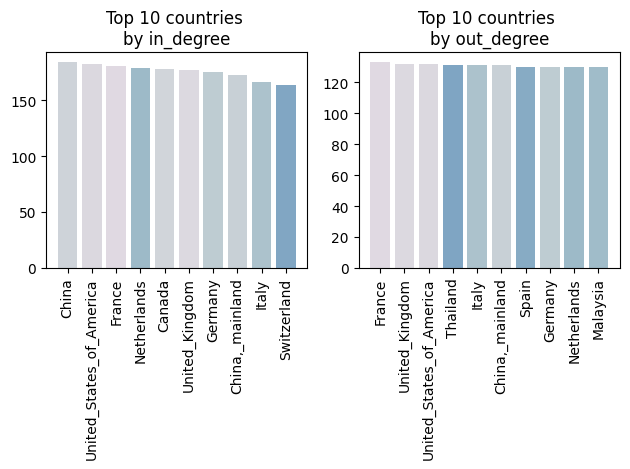

In [20]:
# top 10 in and out degree
plt.subplot(1, 2, 1)
plot_top_k_centralities(centralities, 10, "in_degree")

plt.subplot(1, 2, 2)
plot_top_k_centralities(centralities, 10, "out_degree")

plt.show()

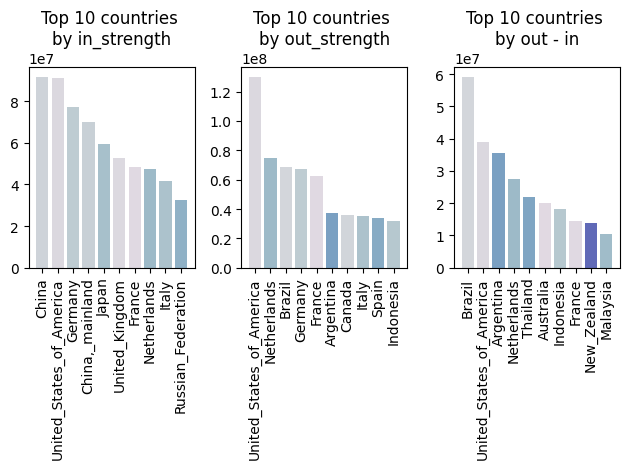

In [21]:
# top 10 in and out strength (+ difference)
plt.subplot(1, 3, 1)
plot_top_k_centralities(centralities, 10, "in_strength")

plt.subplot(1, 3, 2)
plot_top_k_centralities(centralities, 10, "out_strength")

plt.subplot(1, 3, 3)
plot_top_k_centralities(centralities, 10, "out - in")

plt.show()

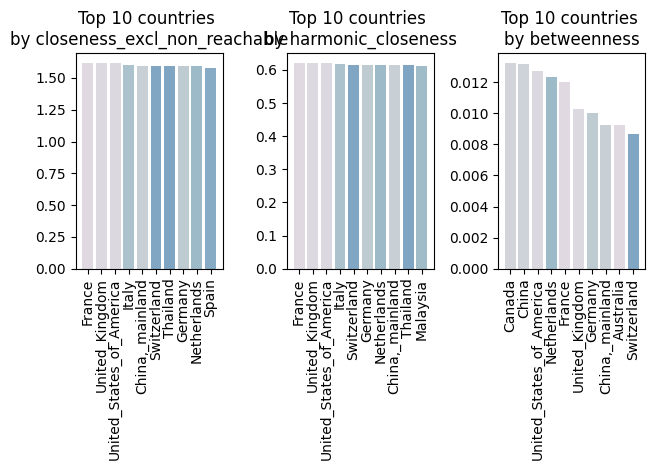

In [22]:
# top 10 closeness and betweenness
plt.subplot(1, 3, 1)
plot_top_k_centralities(centralities, 10, "closeness_excl_non_reachable")

plt.subplot(1, 3, 2)
plot_top_k_centralities(centralities, 10, "harmonic_closeness")

plt.subplot(1, 3, 3)
plot_top_k_centralities(centralities, 10, "betweenness")

plt.show()

In [23]:
# (NOTE: we can observe that all closeness are 0 because the graph is not connected)
centralities["closeness"].describe()

count    214.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: closeness, dtype: float64

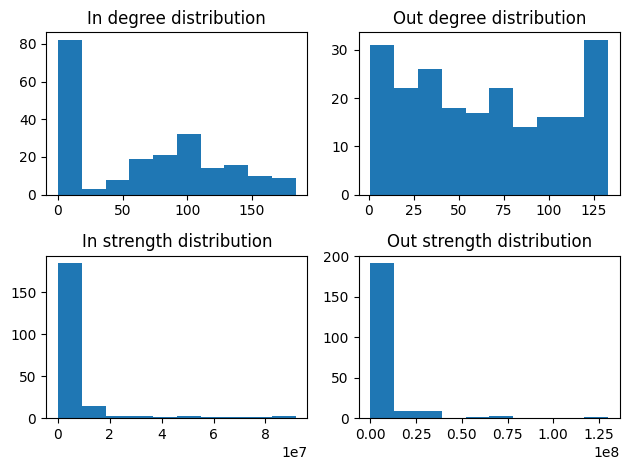

In [24]:
# display degree and strength distributions
bins=10

plt.subplot(2, 2, 1)
plt.hist(centralities["in_degree"], bins=bins)
plt.title("In degree distribution")
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.hist(centralities["out_degree"], bins=bins)
plt.title("Out degree distribution")
plt.tight_layout()


plt.subplot(2, 2, 3)
plt.hist(centralities["in_strength"], bins=bins)
plt.title("In strength distribution")
plt.tight_layout()


plt.subplot(2, 2, 4)
plt.hist(centralities["out_strength"], bins=bins)
plt.title("Out strength distribution")
plt.tight_layout()

del bins
plt.show()

Observations: 

- out-degree distribution seems quite uniform, while other distributions seems to have a long tail
- we will deepen the analysis of the distributions later

In [25]:
# given the centralities, we may derive some topological measures

# calculate max and average degree
topological["max_in_degree"] = max(centralities["in_degree"])
topological["avg_in_degree"] = np.mean(centralities["in_degree"])
topological["max_out_degree"] = max(centralities["out_degree"])
topological["avg_out_degree"] = np.mean(centralities["out_degree"])

# calculate max and average strenghs
topological["max_in_strength"] = max(centralities["in_strength"])
topological["avg_in_strength"] = np.mean(centralities["in_strength"])
topological["max_out_strength"] = max(centralities["out_strength"])
topological["avg_out_strength"] = np.mean(centralities["out_strength"])

# calculate the diameter and the average distance
non_infty_dist = [d for node in dist.keys() for d in dist[node].values()  if d != np.inf]
topological["diameter"] = max(non_infty_dist)
topological["avg_distance"] = np.mean(non_infty_dist)


print("Max in degree: ", topological["max_in_degree"])
print("Avg in degree: ", topological["avg_in_degree"])
print("Max out degree: ", topological["max_out_degree"])
print("Avg out degree: ", topological["avg_out_degree"])
print("Max in strength: ", topological["max_in_strength"])
print("Avg in strength: ", topological["avg_in_strength"])
print("Max out strength: ", topological["max_out_strength"])
print("Avg out strength: ", topological["avg_out_strength"])
print("Max distance (Diameter) excluding infty: ", topological["diameter"])
print("Avg distance  excluding infty: ", topological["avg_distance"])


Max in degree:  184
Avg in degree:  64.18691588785046
Max out degree:  133
Avg out degree:  64.18691588785046
Max in strength:  91670308
Avg in strength:  5184555.219626168
Max out strength:  130060548
Avg out strength:  5184555.219626168
Max distance (Diameter) excluding infty:  3.0
Avg distance  excluding infty:  1.508566023193077


### Centrality indexes (pt. 2 - Clustering) 

What are the clustering coefficients of the network? How do they change if we consieder mutual relationships only?

In [26]:
# calculate nodes clustering coefficients
undir_g = all_layers_g.to_undirected()
undir_g_mutual_only = all_layers_g.to_undirected(reciprocal=True)

# calculate nodes clustering coefficients
centralities["clustering"] = nx.clustering(undir_g)
centralities["clustering_mutual_only"] = nx.clustering(undir_g_mutual_only)

# calculate Watts-Strogatz clustering coefficient
topological["watts_strogatz_clustering"] = np.mean(centralities["clustering"])
topological["watts_strogatz_clustering_mutual_only"] = np.mean(centralities["clustering_mutual_only"])

# calculate Newman clustering coefficient
def newmann_clustering(g: nx.Graph):

    # calculate actual triangles in the graph
    # (do not count the same triangle 3 times)
    n_triangles = sum(nx.triangles(g).values())/3 
    
    # calculate max # of triangles in the graph
    max_n_triangles = 0
    for node_degree in dict(g.degree()).values():
        max_n_triangles += node_degree*(node_degree-1)
  
    max_n_triangles /= 2    # do not couunt undirected paths twice
    max_n_triangles /= 3   # do not count the same triangle 3 times

    return n_triangles/max_n_triangles

topological["newmann_clustering"] = newmann_clustering(undir_g)
topological["newmann_clustering_mutual_only"] = newmann_clustering(undir_g_mutual_only)

print("Watts-Strogatz clustering: ", topological["watts_strogatz_clustering"])
print("Watts-Strogatz clustering (mutual only): ", topological["watts_strogatz_clustering_mutual_only"])
print("Newmann clustering: ", topological["newmann_clustering"])
print("Newmann clustering (mutual only): ", topological["newmann_clustering_mutual_only"])

Watts-Strogatz clustering:  0.8124991062175767
Watts-Strogatz clustering (mutual only):  0.5037041933256556
Newmann clustering:  0.7003534377654634
Newmann clustering (mutual only):  0.6928302663632101


### Centrality indexes (pt. 3 - Spectral Indexes, Random Walks, Kats) 

In [27]:
A = nx.adjacency_matrix(all_layers_g).todense()
np.all(A > 0)

False

In [28]:
# calculate eigenvalues and Spectral Ratio
eigvals = np.linalg.eigvals(A)
eigvals_abs = np.abs(eigvals)
topological["spectral_ratio"] = max(eigvals_abs)

print("Spectral ratio: ", topological["spectral_ratio"])
print("Is spectral ratio an eigenvalue?", topological["spectral_ratio"] in eigvals)
print("Is spectral ratio dominant?", topological["spectral_ratio"] > max(eigvals_abs[1:]))
print("Is spectral ratio simple?", list(eigvals).count(topological["spectral_ratio"]) == 1)

Spectral ratio:  33708163.19482666
Is spectral ratio an eigenvalue? True
Is spectral ratio dominant? False
Is spectral ratio simple? True


Comments:
- `A` is not `> 0`, so Perron theorem does not apply
- `A` is reducible (associated graph is not strongly connected), so neither Frobenius applies
- spectral ratio is an eigevalue but is not dominant, so Power Method does not necessarily converge


C:\Users\Proprietario\AppData\Local\Temp\ipykernel_13156\3601241580.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


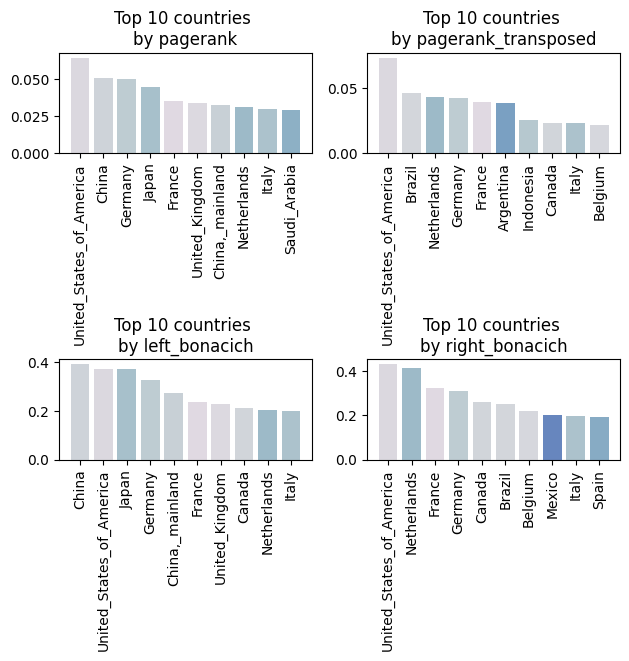

In [29]:
# compute pagerank
centralities["pagerank"] = nx.pagerank(all_layers_g, weight="weight")

# compute pagerank on transposed matrix (to get the out-degree pagerank)
centralities["pagerank_transposed"] = nx.pagerank(all_layers_g.reverse(), weight="weight")

# compute bonacich
centralities["left_bonacich"] = nx.eigenvector_centrality(all_layers_g, weight="weight")
centralities["right_bonacich"] = nx.eigenvector_centrality(all_layers_g.reverse(), weight="weight")

plt.subplot(2, 2, 1)
plot_top_k_centralities(centralities, 10, "pagerank")

plt.subplot(2, 2, 2)
plot_top_k_centralities(centralities, 10, "pagerank_transposed")

plt.subplot(2, 2, 3)
plot_top_k_centralities(centralities, 10, "left_bonacich")

plt.subplot(2, 2, 4)
plot_top_k_centralities(centralities, 10, "right_bonacich")



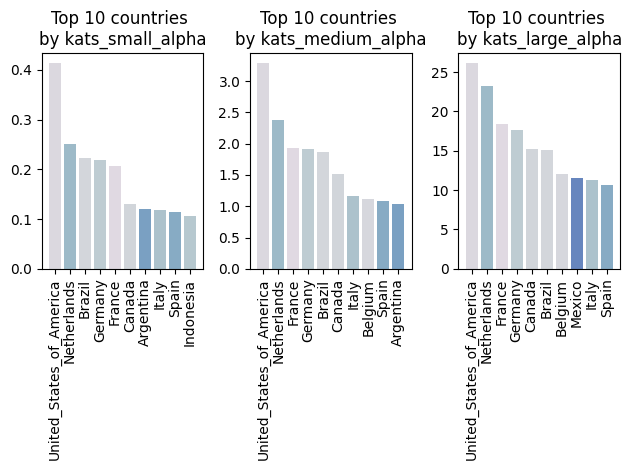

In [30]:
# compute katz
def kats_centrality(g: nx.Graph, alpha: float, weight: str=None):
    """
    Compute the Katz centrality of the nodes of the graph g.
    """

    n = g.number_of_nodes()

    A = nx.adjacency_matrix(g, weight=weight).todense()
    I = np.eye(n)

    # solve linear system
    res =  np.linalg.inv(I - alpha*A) @ np.ones(n)

    # apply final correction 
    res -= np.ones(n)

    # return to a format with node labels
    return {node: res[i] for i, node in enumerate(g.nodes())}

# find a suitable alpha
max_alpha = 1/topological["spectral_ratio"]

# compute katz
centralities["kats_small_alpha"] = kats_centrality(all_layers_g, max_alpha*0.1, weight="weight")
centralities["kats_medium_alpha"] = kats_centrality(all_layers_g, max_alpha*0.5, weight="weight")
centralities["kats_large_alpha"] = kats_centrality(all_layers_g, max_alpha*0.9, weight="weight")

plt.subplot(1, 3, 1)
plot_top_k_centralities(centralities, 10, "kats_small_alpha")

plt.subplot(1, 3, 2)
plot_top_k_centralities(centralities, 10, "kats_medium_alpha")

plt.subplot(1, 3, 3)
plot_top_k_centralities(centralities, 10, "kats_large_alpha")


### Network non-randomness, degree distributions and models

Given the centralities and the topological measures, which properties are explained by randomnness and which are not? Which network model may explain our network?

In [31]:
def expected_topological_props(topological: dict) -> dict: 
    """
    Calculate expected topological properties 
    if the network was an Erdos-Rényi random graph.
    """

    topological_expected = {} 

    # calculate probability of a link
    p = topological["m"]/pow(topological["n"], 2)
    topological_expected["p"] = p

    # average in and out degree is the same and can be calculated as p*(n-1)
    topological_expected["avg_in_degree"] = \
        topological_expected["avg_out_degree"] = \
        p*(topological["n"]-1)


    # average distance is log(n)/log(avg_out_degree)
    topological_expected["avg_distance"] = np.log(topological["n"])/np.log(topological_expected["avg_out_degree"])

    # expected clustering is p (both for Watts-Strogatz and Newmann)
    topological_expected["watts_strogatz_clustering"] = \
        topological_expected["watts_strogatz_clustering_mutual_only"] = \
        topological_expected["newmann_clustering"] = \
        topological_expected["newmann_clustering_mutual_only"] = p
    
    return topological_expected

# calculate expected topological properties if the network was random
topological_expected = expected_topological_props(topological)

print("Expected vs actual avg in degree:\t", 
    round(topological_expected["avg_in_degree"], 2), 
    round(topological["avg_in_degree"], 2))
print("Expected vs actual avg out degree:\t", 
    round(topological_expected["avg_out_degree"], 2),
    round(topological["avg_out_degree"], 2))
print("Expected vs actual avg distance:\t", 
    round(topological_expected["avg_distance"], 2),
    round(topological["avg_distance"], 2))
print("Expected vs actual Watts-Strogatz clustering:\t\t\t", 
    round(topological_expected["watts_strogatz_clustering"], 2),
    round(topological["watts_strogatz_clustering"], 2))
print("Expected vs actual Watts-Strogatz clustering (mutual only):\t", 
    round(topological_expected["watts_strogatz_clustering_mutual_only"], 2),
    round(topological["watts_strogatz_clustering_mutual_only"], 2))
print("Expected vs actual Newmann clustering:\t\t\t\t", 
    round(topological_expected["newmann_clustering"], 2),
    round(topological["newmann_clustering"], 2))
print("Expected vs actual Newmann clustering (mutual only):\t\t", 
    round(topological_expected["newmann_clustering_mutual_only"], 2),
    round(topological["newmann_clustering_mutual_only"], 2))

# moreover, we can check if lim n->inf (n/spectral_ratio) = p
print("Expected vs actual n/spectral_ratio:\t",
    round(topological_expected["p"], 2), 
    round(topological["n"]/topological["spectral_ratio"], 8)) 


Expected vs actual avg in degree:	 63.89 64.19
Expected vs actual avg out degree:	 63.89 64.19
Expected vs actual avg distance:	 1.29 1.51
Expected vs actual Watts-Strogatz clustering:			 0.3 0.81
Expected vs actual Watts-Strogatz clustering (mutual only):	 0.3 0.5
Expected vs actual Newmann clustering:				 0.3 0.7
Expected vs actual Newmann clustering (mutual only):		 0.3 0.69
Expected vs actual n/spectral_ratio:	 0.3 6.35e-06


In [32]:
class Histogram:
    """Class to represent frequencies distribution of a list of values"""
    
    def __init__(self, values: List[float]):

        self.values = np.array(values)
        
        # count the number of occurrences of each value
        unique, counts = np.unique(self.values, return_counts=True)

        # zip everything into an unique array
        self.occurrences = np.array(list(zip(unique, counts)))

        # sort by value
        self.occurrences = self.occurrences[self.occurrences[:, 0].argsort()]

    def get_histogram(self, loglog_scale=False) -> List[Tuple[float, int]]:

        """Return the histogram as a list of tuples (value, occurrences)"""
        return self.apply_loglog_scale(self.occurrences.tolist(), loglog_scale)

    def get_distribution(self, loglog_scale=False) -> List[Tuple[float, float]]:

        """Return the distribution as a list of tuples (value, probability)"""
        return self.apply_loglog_scale(
            list(zip(self.occurrences[:, 0], self.__probabilities())), 
            loglog_scale
        )
    
    def __probabilities(self) -> List[float]:
        """Return the probabilities of each value"""
        return self.occurrences[:, 1]/self.occurrences[:, 1].sum()
    
    def get_complementary_cumulative_distribution(self, loglog_scale=False) -> List[Tuple[float, float]]:

        """Return the complementary cumulative distribution as a list of tuples (value, probability)"""

        return self.apply_loglog_scale(
            list(zip(self.occurrences[:, 0], 
                np.flip(np.cumsum(np.flip(self.__probabilities())))
            )), 
            loglog_scale
        )
    
    def apply_loglog_scale(self, x: List[Tuple[float, float]], apply=True) -> List[Tuple[float, float]]:
        """(Eventually) Apply loglog scale to a list of tuples (value, probability|occurrences). 
        If apply is False, just return the list as it is."""

        if apply:

            # eventual 0 values are not allowed in log scale => they are replaced with min(1, min(x))
            if x[0][0] == 0:
                min_x = min([x for x, y in x if x != 0])
                x[0] = (min(1, min_x), x[0][1])

            return [(np.log10(x), np.log10(y)) for x, y in x]
        return x

Before we have done a quick overview on the degrees and strengths distributions, that suggested that in-degree, in-strength and out-strength have a long tail. We may try to plot Complemetary Cumulative Distributions in a log-log scale to see if they follow a power law pattern.

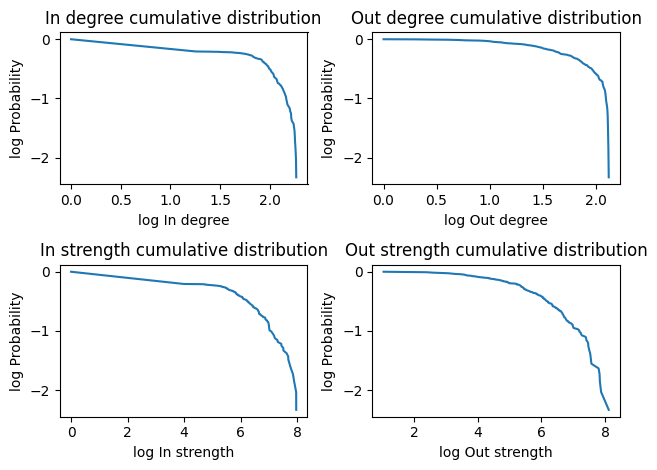

In [33]:
# calculate Complementary Cumulative Distribution
# for in-out degree and in-out strength

histogram_in_degree = Histogram(centralities["in_degree"])
histogram_out_degree = Histogram(centralities["out_degree"])
histogram_in_strength = Histogram(centralities["in_strength"])
histogram_out_strength = Histogram(centralities["out_strength"])

plt.subplot(2, 2, 1)
plt.title("In degree cumulative distribution")
plt.xlabel("log In degree")
plt.ylabel("log Probability")
plt.plot(*zip(*histogram_in_degree.get_complementary_cumulative_distribution(loglog_scale=True)))
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.title("Out degree cumulative distribution")
plt.xlabel("log Out degree")
plt.ylabel("log Probability")
plt.plot(*zip(*histogram_out_degree.get_complementary_cumulative_distribution(loglog_scale=True)))
plt.tight_layout()


plt.subplot(2, 2, 3)
plt.title("In strength cumulative distribution")
plt.xlabel("log In strength")
plt.ylabel("log Probability")
plt.plot(*zip(*histogram_in_strength.get_complementary_cumulative_distribution(loglog_scale=True)))
plt.tight_layout()


plt.subplot(2, 2, 4)
plt.title("Out strength cumulative distribution")
plt.xlabel("log Out strength")
plt.ylabel("log Probability")
plt.plot(*zip(*histogram_out_strength.get_complementary_cumulative_distribution(loglog_scale=True)))
plt.tight_layout()

plt.show()

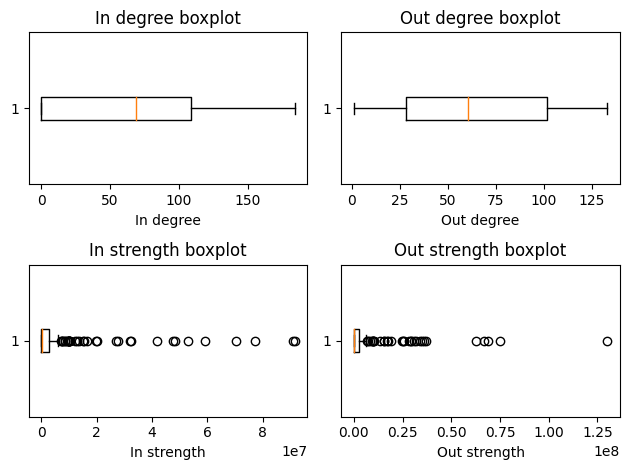

In [34]:
# display also some boxplots

plt.subplot(2, 2, 1)
plt.title("In degree boxplot")
plt.xlabel("In degree")
plt.boxplot(histogram_in_degree.values, vert=False)
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.title("Out degree boxplot")
plt.xlabel("Out degree")
plt.boxplot(histogram_out_degree.values, vert=False)
plt.tight_layout()


plt.subplot(2, 2, 3)
plt.title("In strength boxplot")
plt.xlabel("In strength")
plt.boxplot(histogram_in_strength.values, vert=False)
plt.tight_layout()


plt.subplot(2, 2, 4)
plt.title("Out strength boxplot")
plt.xlabel("Out strength")
plt.boxplot(histogram_out_strength.values, vert=False)
plt.tight_layout()

plt.show()

Observation: 
- even if a quick overview of in-out degree and strength distributions may suggest a power-law distribution, a more accurate analysis on Complementary Cumulative Distributions shows that the distributions seem not power-laws.
- using boxplots, we observe degrees distributions are quite compact, while strength distributions still have long tails (but CCDs tell us that they are not power-laws)
  - if they were power laws, they would have a fatter tail 
- if we exclude nodes with no in-edges, in-degree distribution seems to follow a bell-shaped curve, while out-degree distribution seems to follow something pseudo-uniform


In [35]:
# calculate degree heterogeneity

def inverse_partecipation_ratio(values: List[float]) -> float:
    """Calculate the inverse partecipation ratio of a list of values"""
    return sum([x**2 for x in values])/(sum(values)**2)

def degree_heterogeneity(values: List[float]) -> float:
    """Calculate the heterogeneity of a list of values"""
    return 1/inverse_partecipation_ratio(values)

print("In degree heterogeneity (and IPR):\t", 
      round(degree_heterogeneity(centralities["in_degree"]), 2), "\t", 
      round(inverse_partecipation_ratio(centralities["in_degree"]), 2)
      )
print("Out degree heterogeneity (and IPR):\t", 
      round(degree_heterogeneity(centralities["out_degree"]), 2), "\t",
      round(inverse_partecipation_ratio(centralities["out_degree"]), 2)
      )
print("In strength IPR:\t", 
      round(inverse_partecipation_ratio(centralities["in_strength"]), 2)
      )
print("Out strength IPR:\t", 
      round(inverse_partecipation_ratio(centralities["out_strength"]), 2)
      ) 

# calculate mean and median
print("")

print("In degree mean and median:\t", 
      round(np.mean(centralities["in_degree"]), 2), "\t", 
      round(np.median(centralities["in_degree"]), 2))
print("Out degree mean and median:\t", 
      round(np.mean(centralities["out_degree"]), 2), "\t", 
      round(np.median(centralities["out_degree"]), 2))
print("In strength mean and median:\t", 
      round(np.mean(centralities["in_strength"]), 2), "\t", 
      round(np.median(centralities["in_strength"]), 2))
print("Out strength mean and median:\t", 
      round(np.mean(centralities["out_strength"]), 2), "\t", 
      round(np.median(centralities["out_strength"]), 2))

In degree heterogeneity (and IPR):	 117.41 	 0.01
Out degree heterogeneity (and IPR):	 151.21 	 0.01
In strength IPR:	 0.04
Out strength IPR:	 0.04

In degree mean and median:	 64.19 	 68.5
Out degree mean and median:	 64.19 	 60.5
In strength mean and median:	 5184555.22 	 366666.0
Out strength mean and median:	 5184555.22 	 310686.0


Observations: 
- IPR and degree heterogeneity suggest that distributions are not uniform, but there is heterogeneity 
- In in-degree, in-strength and out-strength, mean values are greater than median values, so distributions are right-skewed

### Centrality correlations

Given all calculated centralities, we may look for correlations between them.

In [36]:
# calculate Pearson correlation between each pair of centrality indexes
cormatrix = pd.DataFrame(np.corrcoef(centralities.to_numpy().T), columns=centralities.columns, index=centralities.columns)

# display (as example) all the correlations of out_strength
cormatrix["out_strength"]

c:\Users\Proprietario\Desktop\codici git\ADS_trade\.venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Proprietario\Desktop\codici git\ADS_trade\.venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


in_degree                       0.502949
out_degree                      0.517125
in_strength                     0.753794
out_strength                    1.000000
out - in                        0.384516
closeness                            NaN
closeness_excl_non_reachable    0.585547
harmonic_closeness              0.513491
betweenness                     0.755350
clustering                     -0.525635
clustering_mutual_only          0.081015
pagerank                        0.728162
pagerank_transposed             0.987092
left_bonacich                   0.719359
right_bonacich                  0.955310
kats_small_alpha                0.999365
kats_medium_alpha               0.987634
kats_large_alpha                0.964212
Name: out_strength, dtype: float64

In [37]:
# turn the matrix into a list of pairs (i1, i2, pearson_cor), 
# sort by pearson_cor descending 
# (if we want to easily find out the most correlated pairs)

corpairs = pd.melt(cormatrix.reset_index(), id_vars="index")\
    .rename(columns={
        "index": "i1", 
        "variable": "i2",
        "value": "pearson_cor"
    }).dropna()\
    .query("i1 < i2")\
    .sort_values(by="pearson_cor", ascending=False)\
    .reset_index(drop=True)

corpairs.head()

,i1,i2,pearson_cor
0,kats_small_alpha,out_strength,0.999365
1,kats_large_alpha,right_bonacich,0.999281
2,harmonic_closeness,out_degree,0.998684
3,kats_large_alpha,kats_medium_alpha,0.993225
4,kats_medium_alpha,kats_small_alpha,0.992552


### Meso-scale structures (pt. 1 - Visual methods and k-core)

In this part we will apply various algorithms and visual methods to try to find some meso-scale structures in the network.

In [38]:
# define a method to generate a copy of a graph according to a node sorting
# (useful to plot the matrix where node are sorted by 
# degree, strength, eigenvector, etc.)

def generate_graph_from_nodes_sorting(
        g: nx.Graph, 
        sorted_nodes: List[str], 
        build_matrix_entry=None, 
        create_using=None) -> nx.Graph:
    """Create a copy of the graph, but with the nodes sorted 
    according to the given list of nodes. 
    
    Tou can specify a procedure build_matrix_entry(g, n1, n2) to 
    tell how to build the matrix entry for the edge between n1 and n2.

    If create_using is specified, the new graph will be created using that method
    (e.g. nx.DiGraph)
    """


    new_A = np.zeros((len(all_layers_g.nodes), len(all_layers_g.nodes)))

    for i, node in enumerate(sorted_nodes):
        for j, node2 in enumerate(sorted_nodes):
            if all_layers_g.has_edge(node, node2):

                if build_matrix_entry is None:
                    new_A[i, j] = 1
                else: 
                    new_A[i, j] = build_matrix_entry(all_layers_g, node, node2)


    return nx.from_numpy_array(new_A, create_using=create_using)




Text(0.5, 1.0, 'Node sorted by in+out strength,\nlog10(weight) matrix')

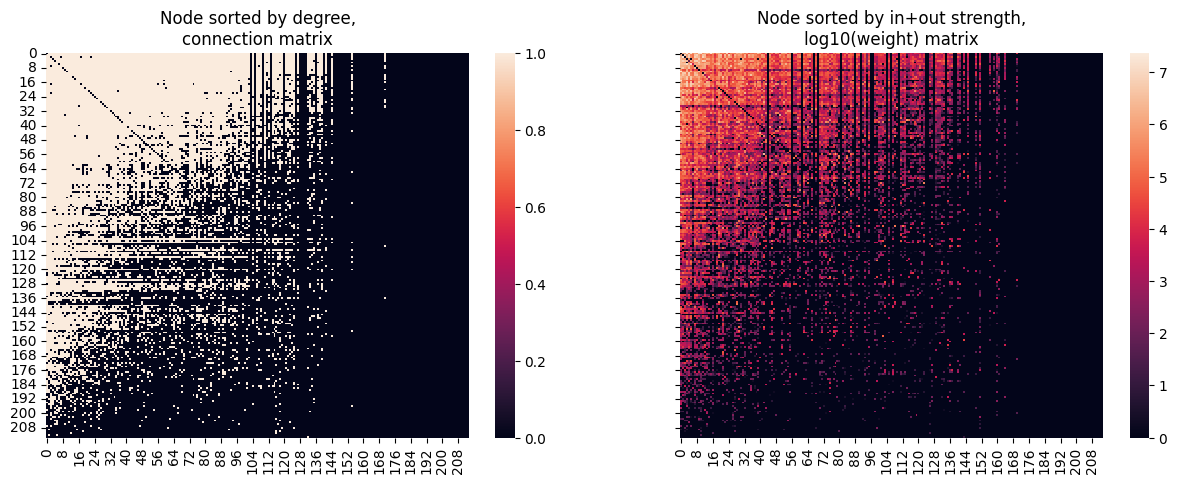

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# rename node labels by descending degree and plot connection matrix
sns.heatmap(
    nx.adjacency_matrix(generate_graph_from_nodes_sorting(
        all_layers_g, [ node for (node, _) in 
         sorted(all_layers_g.degree, key=lambda x: x[1], reverse=True) ], 
        create_using=nx.DiGraph
    )).todense(), ax=axes[0])
axes[0].set_title("Node sorted by degree,\nconnection matrix")


sns.heatmap(
    nx.adjacency_matrix(generate_graph_from_nodes_sorting(
        all_layers_g, [ node for (node, _) in 
         sorted(all_layers_g.degree(weight="weight"), key=lambda x: x[1], reverse=True) ], 
        build_matrix_entry=lambda g, n1, n2: math.log10(g.edges[n1, n2]["weight"]),
        create_using=nx.DiGraph
    )).todense(), ax=axes[1])
axes[1].set_title("Node sorted by in+out strength,\nlog10(weight) matrix")


Text(0.5, 1.0, 'Node sorted by lambda_n,\nlog10(weight) matrix')

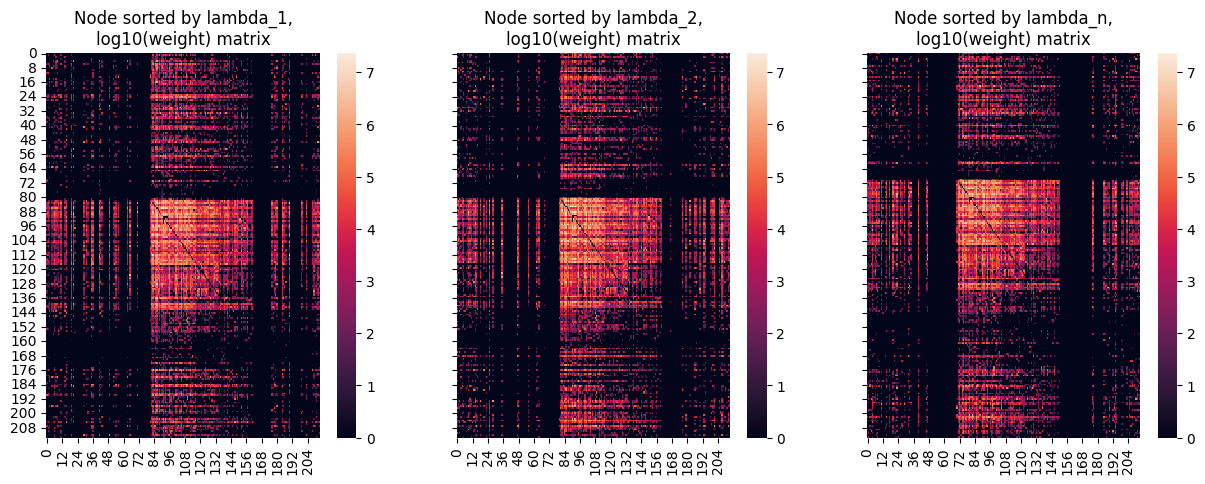

In [40]:
# rename node labels by descending lambda_1, lambda_2 and lambda_3 and plot matrix the same way

# calculate the eigenvectors of the adjacency matrix
# and the eigenvectors values for each node
eig = np.linalg.eig(nx.adjacency_matrix(all_layers_g).todense())
eig = sorted(zip(eig[0], eig[1]), key=lambda x: x[0], reverse=True)

node_names = list(all_layers_g.nodes)

eig_1 = []
eig_2 = []
eig_n = []

for i in range(len(node_names)):
    eig_1.append((node_names[i], eig[0][1][i]))
    eig_2.append((node_names[i], eig[1][1][i]))
    eig_n.append((node_names[i], eig[-1][1][i]))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.heatmap(
    nx.adjacency_matrix(generate_graph_from_nodes_sorting(
        all_layers_g, [ node for (node, _) in sorted(eig_1, key=lambda x: x[1], reverse=True) ],
        build_matrix_entry=lambda g, n1, n2: math.log10(g.edges[n1, n2]["weight"]),
        create_using=nx.DiGraph
    )).todense(), ax=axes[0])
axes[0].set_title("Node sorted by lambda_1,\nlog10(weight) matrix")

sns.heatmap(
    nx.adjacency_matrix(generate_graph_from_nodes_sorting(
        all_layers_g, [ node for (node, _) in sorted(eig_2, key=lambda x: x[1], reverse=True) ],
        build_matrix_entry=lambda g, n1, n2: math.log10(g.edges[n1, n2]["weight"]),
        create_using=nx.DiGraph
    )).todense(), ax=axes[1])
axes[1].set_title("Node sorted by lambda_2,\nlog10(weight) matrix")

sns.heatmap(
    nx.adjacency_matrix(generate_graph_from_nodes_sorting(
        all_layers_g, [ node for (node, _) in sorted(eig_n, key=lambda x: x[1], reverse=True) ],
        build_matrix_entry=lambda g, n1, n2: math.log10(g.edges[n1, n2]["weight"]),
        create_using=nx.DiGraph
    )).todense(), ax=axes[2])
axes[2].set_title("Node sorted by lambda_n,\nlog10(weight) matrix")




In [41]:
# implement k-core (networkx has a function for it, 
# but running it seems taking so much time)

class KCore: 

    def __init__(self, G: nx.Graph, get_nodes_k_values=None, get_min_k_value=None):
        
        if get_nodes_k_values is None:
            self.get_nodes_k_values = lambda G: G.degree()
        else:
            self.get_nodes_k_values = get_nodes_k_values

        if get_min_k_value is None:

            def __get_min_k_value(g: nx.Graph, k: int):
                d = list(dict(g.degree()).values())
                if len(d) > 0:
                    return min(d)
                return k
            
            self.get_min_k_value = __get_min_k_value
        else:
            self.get_min_k_value = get_min_k_value

        self.__compute(G)

    def __compute(self, G: nx.Graph):
        
        k = 0
        prec_k = 0  
        self.G_k = { k: G.copy() }

        while self.G_k[prec_k].number_of_nodes() > 0:

            # get next k
            k = self.get_min_k_value(self.G_k[prec_k], k) + 1

            # compute k-core of G_k[k]
            self.G_k[k] = self.__compute_k_core(self.G_k[prec_k].copy(), k)

            prec_k = k

    def __compute_k_core(self, G: nx.Graph, k: int) -> nx.Graph:
        """Compute the k-core of a graph"""

        no_nodes_removed = True
        for v in list(G.nodes()):
            if self.get_nodes_k_values(G)[v] < k:
                G.remove_node(v)
                no_nodes_removed = False

        if no_nodes_removed:
            return G
        
        return self.__compute_k_core(G, k)
    
    def degeneracy_index(self) -> int:
        """Compute the degeneracy index of a graph (the last k associated to a non-empty graph)"""

        return self.get_k_values()[-1]
    
    def get_k_values(self) -> List[int]:
        """Get the sorted k values of a graph (excluding the last empty one)"""
        
        return list(self.G_k.keys())[0:-1]
    
    def get_k_shells(self) -> Dict[int, nx.Graph]:
        """Get the k-shells of a graph"""

        keys = list(self.G_k.keys())
        res = {}

        for i in range(1, len(keys)): 
            res[keys[i-1]] = self.G_k[keys[i-1]].copy()
            res[keys[i-1]].remove_nodes_from(self.G_k[keys[i]].nodes())

        res[i-1] = self.G_k[keys[i-1]].copy()
        
        return res

# compute k-cores of the graph
kcore_on_connections = KCore(all_layers_g.to_undirected())

# calculate degeneracy index
print("Degeneracy index:\t", kcore_on_connections.degeneracy_index())

Degeneracy index:	 79


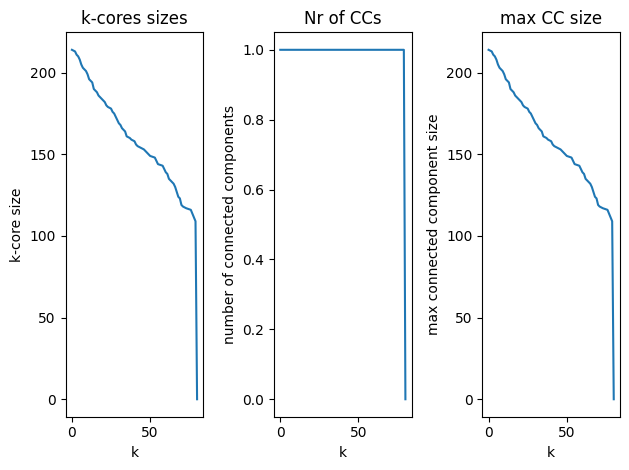

In [42]:
# get the k-cores sizes, number of connected components, ecc.
cores = kcore_on_connections.G_k

sizes = []
cc_n = []
cc_max_size = []

for k in cores.keys():
    sizes.append(cores[k].number_of_nodes())
    cc = list(nx.connected_components(cores[k]))
    cc_n.append(len(cc))
    
    cc_sizes = [len(c) for c in cc]
    if len(cc_sizes) > 0:
        cc_max_size.append(max(cc_sizes))
    else:
        cc_max_size.append(0)

# plot k-cores resume
plt.subplot(1, 3, 1)
plt.plot(list(cores.keys()), sizes)
plt.xlabel("k")
plt.ylabel("k-core size")
plt.title("k-cores sizes")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(list(cores.keys()), cc_n)
plt.xlabel("k")
plt.ylabel("number of connected components")
plt.title("Nr of CCs")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(list(cores.keys()), cc_max_size)
plt.xlabel("k")
plt.ylabel("max connected component size")
plt.title("max CC size")
plt.tight_layout()

plt.show()


In [43]:
# get the k-shells
shells = kcore_on_connections.get_k_shells()
for k in shells.keys():
    print("K-shell ", k, ":\t", shells[k].nodes())

del shells

K-shell  0 :	 ['Andorra']
K-shell  2 :	 ['Tuvalu', 'Saint_Pierre_and_Miquelon']
K-shell  3 :	 ['Saint_Helena,_Ascension_and_Tristan_da_Cunha']
K-shell  4 :	 ['Niue', 'Mayotte']
K-shell  5 :	 ['Equatorial_Guinea', 'Montserrat', 'Palau']
K-shell  6 :	 ['Kiribati', 'Nauru']
K-shell  7 :	 ['Micronesia_(Federated_States_of)', 'Falkland_Islands_(Malvinas)']
K-shell  9 :	 ['Guinea-Bissau', 'Faroe_Islands']
K-shell  10 :	 ['American_Samoa', 'Greenland', 'Cook_Islands']
K-shell  11 :	 ['Brunei_Darussalam']
K-shell  12 :	 ['Lesotho']
K-shell  13 :	 ['Eritrea', 'Marshall_Islands', 'Angola', 'Timor-Leste']
K-shell  14 :	 ['Guam']
K-shell  15 :	 ['Sao_Tome_and_Principe']
K-shell  16 :	 ['British_Virgin_Islands', 'Cayman_Islands']
K-shell  17 :	 ['Turks_and_Caicos_Islands']
K-shell  18 :	 ['Saint_Lucia']
K-shell  19 :	 ['Samoa', 'Saint_Kitts_and_Nevis']
K-shell  21 :	 ['Occupied_Palestinian_Territory', 'Chad']
K-shell  22 :	 ['Bhutan']
K-shell  23 :	 ['Bermuda']
K-shell  25 :	 ['Somalia', 'Djibouti'

Observations and notes: 

- k-core algorithm and (degree and strength matricies) plots may suggest a presence of a core-periphery structure, where we have a center of high degree and strength nodes, and a periphery of low degree and strength nodes
- (potentially we could think about a k-core variant based on weights, but we will not do it here)

### Meso-scale structures (pt. 2 - Modularity based methods) 

In [44]:
# Apply louvian algorithm to the graph (with and without weights)
# (then make some comparisons)

communities = {}
w_communities = {}
res_params = [0.4, 0.8, 1, 1.2, 1.6,]

print("Louvian algorithm results (without weights)")
for rp in res_params:

    communities[rp] = nx.community.louvain_communities(
        all_layers_g, resolution=rp)
    communities[rp] = sorted(
        communities[rp], key=lambda x: len(x), reverse=True)
    
    comm_sizes = [len(c) for c in communities[rp]]
    print(
        f"(res param={rp}) Nr of communities:", 
        len(communities[rp]), 
        "\tsizes:", comm_sizes)


print("\nLouvian algorithm results (with weights)")
for rp in res_params:

    w_communities[rp] = nx.community.louvain_communities(
        all_layers_g, resolution=rp, weight="weight")
    w_communities[rp] = sorted(w_communities[rp], key=lambda x: len(x), reverse=True)
    comm_sizes = [len(c) for c in w_communities[rp]]
    print(
        f"(res param={rp}) Nr of communities:", 
        len(w_communities[rp]), 
        "\tsizes:", comm_sizes)



Louvian algorithm results (without weights)
(res param=0.4) Nr of communities: 4 	sizes: [103, 73, 35, 3]
(res param=0.8) Nr of communities: 7 	sizes: [87, 68, 20, 16, 16, 4, 3]
(res param=1) Nr of communities: 8 	sizes: [59, 57, 39, 19, 16, 16, 5, 3]
(res param=1.2) Nr of communities: 10 	sizes: [56, 49, 33, 19, 19, 16, 11, 5, 3, 3]
(res param=1.6) Nr of communities: 14 	sizes: [34, 34, 22, 20, 19, 18, 16, 14, 13, 7, 6, 5, 3, 3]

Louvian algorithm results (with weights)
(res param=0.4) Nr of communities: 3 	sizes: [114, 97, 3]
(res param=0.8) Nr of communities: 7 	sizes: [88, 74, 16, 16, 13, 4, 3]
(res param=1) Nr of communities: 8 	sizes: [59, 57, 39, 19, 16, 16, 5, 3]
(res param=1.2) Nr of communities: 9 	sizes: [55, 52, 38, 21, 21, 16, 5, 3, 3]
(res param=1.6) Nr of communities: 14 	sizes: [33, 32, 22, 22, 20, 18, 16, 14, 13, 7, 6, 5, 3, 3]


In [45]:
# define some methods to compare communities partitions

def community_array(all_nodes_names: list, community: List[set]) -> np.array:
    """Extract the array of the upper-right triangle of the community matrix"""

    comm_matrix = np.zeros((len(all_nodes_names), len(all_nodes_names)))

    for c in community:
        for (u, v) in itertools.combinations(c, 2):
            i = all_nodes_names.index(u)
            j = all_nodes_names.index(v)
            comm_matrix[i, j] = 1
            comm_matrix[j, i] = 1

    comm_array = []
    for i in range(1, len(all_nodes_names)):
        for j in range(i, len(all_nodes_names)):
            comm_array.append(comm_matrix[i, j])

    return np.array(comm_array)


def rand_index(x: np.array, y: np.array) -> float:
    """Compute the Rand index between two community arrays"""
    return ( x.dot(y) + (1-x).dot(1-y) ) / ( len(x) )


print("Compare weighted and unweighted communities partitions foreach resolution parameter\n")

node_names = list(all_layers_g.nodes)

# make some comparisons:
for rp in res_params:

    c = community_array(node_names, communities[rp])
    w_c = community_array(node_names, w_communities[rp])

    print(
        f"(res param={rp})",
        "Pearson index:", round(np.corrcoef(c, w_c)[0, 1], 2),
        "\tRand index:", round(rand_index(c, w_c), 2)
        )



Compare weighted and unweighted communities partitions foreach resolution parameter

(res param=0.4) Pearson index: 0.56 	Rand index: 0.77
(res param=0.8) Pearson index: 0.94 	Rand index: 0.97
(res param=1) Pearson index: 1.0 	Rand index: 1.0
(res param=1.2) Pearson index: 0.57 	Rand index: 0.88
(res param=1.6) Pearson index: 0.85 	Rand index: 0.97


In [46]:
print("Compare biggest weighted and unweighted communities with last k-core\n")

# get last k-core community vector 
k_core_community_nodes = set(kcore_on_connections.G_k[kcore_on_connections.get_k_values()[-1]].nodes())
k_core_community = [k_core_community_nodes, set(node_names).difference(k_core_community_nodes)]
k_core_comm_vector = community_array(node_names, k_core_community)

c = community_array(node_names, communities[0.4])
w_c = community_array(node_names, w_communities[0.4])

print(f"(unweighted Louvian, res param={rp})",
        "\tPearson index:", round(np.corrcoef(c, k_core_comm_vector)[0, 1], 2),
        "\tRand index:", round(rand_index(c, k_core_comm_vector), 2) )

print(f"(weighted Louvian, res param={rp})",
        "\tPearson index:", round(np.corrcoef(w_c, k_core_comm_vector)[0, 1], 2),
        "\tRand index:", round(rand_index(w_c, k_core_comm_vector), 2) )


Compare biggest weighted and unweighted communities with last k-core

(unweighted Louvian, res param=1.6) 	Pearson index: 0.02 	Rand index: 0.51
(weighted Louvian, res param=1.6) 	Pearson index: 0.03 	Rand index: 0.52


Observations:

- there could or there could not be correlations between communites found using or non using weights (it depends a lot from the resolution parameter)
- there is no correlation between (big) communities found through Louvian and the more dense k-core

### Meso-scale structures (pt. 3 - Core-periphery)

To detect the supposed core-periphery structure, we implement algorithm proposed by Fasino D. and Rinaldi F. in 2020 (https://www.mdpi.com/2073-8994/12/1/94).

In [47]:
# define minimization function z(s)

def core_periphery_z(g: nx.Graph(), center: set, get_edge_value=None) -> int: 
    """Function to minimize to find the core-periphery structure of a graph.
    The smaller the value, the better the core-periphery structure."""

    if get_edge_value is None:
        get_edge_value = lambda g, u, v: g.has_edge(u, v)

    sum_ij_in_center = 0
    for i in center:
        for j in center:
            if i != j:
                sum_ij_in_center += 1-get_edge_value(g, i, j)

    sum_ij_out_center = 0
    periphery = set(g.nodes()).difference(center)
    for i in periphery:
        for j in periphery:
            if i != j:
                sum_ij_out_center += get_edge_value(g, i, j)

    return sum_ij_in_center + sum_ij_out_center

# let's apply the z-measure on previously computed 
# last 2 k-cores (excluding the empty one) and 
# on one of the communities found with the louvian algorithm

last_k_core = kcore_on_connections.G_k[kcore_on_connections.get_k_values()[-1]]
last2_k_core = kcore_on_connections.G_k[kcore_on_connections.get_k_values()[-2]]


center1 = set(last_k_core.nodes())
center2 = set(last2_k_core.nodes())
louvian_center = set(communities[0.4][0])

print("z-score of last 1st last non-empty k-core:\t", core_periphery_z(all_layers_g, center1))
print("z-score of the 2nd last non-empty k-core:\t", core_periphery_z(all_layers_g, center2))
print("z-score of the 1st (unweighted) Louvian community:\t", core_periphery_z(all_layers_g, louvian_center))


z-score of last 1st last non-empty k-core:	 3084
z-score of the 2nd last non-empty k-core:	 3927
z-score of the 1st (unweighted) Louvian community:	 10016


In [48]:
# sort nodes by degree
sorted_nodes = sorted(list(all_layers_g.to_undirected().degree()), key=lambda x: x[1], reverse=True)
sorted_nodes

# select the index k s.t. degree(k) >= k and degree(k) < k+1

for k,node in enumerate(sorted_nodes):
    if node[1] >= k and node[1] < k+1:
        break

print("Found k =", k)

fasino_rinaldi_core = set([node[0] for node in sorted_nodes[:k]])

print("Found core:\t", fasino_rinaldi_core)
print("z-score of found core:\t", core_periphery_z(all_layers_g, fasino_rinaldi_core))

Found k = 98
Found core:	 {'Peru', 'Norway', 'Spain', 'Colombia', 'New_Zealand', 'United_Arab_Emirates', 'Syrian_Arab_Republic', 'Slovenia', 'Lithuania', 'Serbia', 'Qatar', 'China,_Hong_Kong_SAR', 'Malta', 'Uruguay', 'New_Caledonia', 'Sri_Lanka', 'Chile', 'Venezuela_(Bolivarian_Republic_of)', 'Mexico', 'Lebanon', 'Sweden', 'Netherlands', 'South_Africa', 'Ukraine', 'Malaysia', 'Cyprus', 'Portugal', 'Germany', 'Oman', 'Switzerland', 'China', 'China,_Taiwan_Province_of', 'United_Kingdom', 'Ireland', 'Viet_Nam', 'Mauritius', 'Azerbaijan', 'Philippines', 'Ghana', 'Jordan', 'Indonesia', 'Saudi_Arabia', 'Costa_Rica', 'Italy', 'The_former_Yugoslav_Republic_of_Macedonia', 'Jamaica', 'Australia', 'Japan', 'Greece', 'Russian_Federation', 'Morocco', 'Albania', 'Ethiopia', 'Belarus', 'Egypt', 'Bahrain', 'Pakistan', "CÃ´te_d'Ivoire", 'Croatia', 'Ecuador', 'Guatemala', 'Trinidad_and_Tobago', 'Czech_Republic', 'Poland', 'Argentina', 'Cameroon', 'Hungary', 'Iran_(Islamic_Republic_of)', 'Romania', 'Chin

In [49]:
print("Compare found core with some previously found communities\n")

fasino_rinaldi_core_vector = community_array(
    node_names, [
        fasino_rinaldi_core, 
        set(node_names).difference(fasino_rinaldi_core) ])

print("(K-core last core)\t\t", 
        "\tPearson index:", round(np.corrcoef(k_core_comm_vector, fasino_rinaldi_core_vector)[0, 1], 2),
        "\tRand index:", round(rand_index(k_core_comm_vector, fasino_rinaldi_core_vector), 2) )

k_core_comm_vector2 = community_array(node_names, [center2, set(node_names).difference(center2)])

print("(K-core 2nd last core)\t\t",
        "\tPearson index:", round(np.corrcoef(k_core_comm_vector2, fasino_rinaldi_core_vector)[0, 1], 2),
        "\tRand index:", round(rand_index(k_core_comm_vector2, fasino_rinaldi_core_vector), 2) )

print("(unweighted Louvian, res param=0.4)",
        "\tPearson index:", round(np.corrcoef(c, fasino_rinaldi_core_vector)[0, 1], 2),
        "\tRand index:", round(rand_index(c, fasino_rinaldi_core_vector), 2) )

print("(weighted Louvian, res param=0.4)",
        "\tPearson index:", round(np.corrcoef(w_c, fasino_rinaldi_core_vector)[0, 1], 2),
        "\tRand index:", round(rand_index(w_c, fasino_rinaldi_core_vector), 2) )



Compare found core with some previously found communities

(K-core last core)		 	Pearson index: 0.81 	Rand index: 0.9
(K-core 2nd last core)		 	Pearson index: 0.69 	Rand index: 0.85
(unweighted Louvian, res param=0.4) 	Pearson index: 0.01 	Rand index: 0.5
(weighted Louvian, res param=0.4) 	Pearson index: 0.03 	Rand index: 0.52


Observations:

- core-periphery structure does not currespond so much with Louvian communities, but there is some correlation with what have been found through k-core 
- both k-core and Fasino, Rinaldi algorithms, as implemented, ignored weights, so they may be a bit misleading in this context

## Comparative analysis on 3 sample sublayers

We take 3 sample sublayers and we make a comparative analysis on them: 

- we will use the following sublayers: `"Roots and tubers", "Nuts, prepared", "Fruit, dried"`
- on them, we will first calculate some general topological measures
- then, we extract from the matrix a 




In [50]:
# extract the 3 graphs 
g_names = ["Roots_and_tubers,_nes", "Nuts,_prepared_(exc._groundnuts)", "Fruit,_dried_nes"]

g1 = layers_g[g_names[0]]
g2 = layers_g[g_names[1]]
g3 = layers_g[g_names[2]]

In [51]:
topological.keys()

dict_keys(['n', 'm', 'tot_weight', 'density', 'weakly_connected', 'strongly_connected', 'max_in_degree', 'avg_in_degree', 'max_out_degree', 'avg_out_degree', 'max_in_strength', 'avg_in_strength', 'max_out_strength', 'avg_out_strength', 'diameter', 'avg_distance', 'watts_strogatz_clustering', 'watts_strogatz_clustering_mutual_only', 'newmann_clustering', 'newmann_clustering_mutual_only', 'spectral_ratio'])

### Sample layers topological properties overview 

#### (and comparison with expected values if the network was random)

In [52]:
def g_topological_stats(g: nx.DiGraph):

    n = len(g.nodes)
    m = len(g.edges)

    # calculate weighted and not weighted degree
    in_deg = list(dict(g.in_degree()).values())
    in_deg_w = list(dict(g.in_degree(weight='weight')).values())
    out_deg = list(dict(g.out_degree()).values())
    out_deg_w = list(dict(g.out_degree(weight='weight')).values())

    # calculate non-infinite shortest paths
    sp = nx.floyd_warshall(g, weight=None)
    sp = [sp[u][v] for u in sp for v in sp[u] if sp[u][v] != np.inf]

    # calculate eigvals
    ev = np.linalg.eigvals(nx.adjacency_matrix(g).todense())
    ev_abs = np.abs(ev)

    # calculate nodes clustering coefficients
    ud_g = g.to_undirected()
    ud_g_mo = g.to_undirected(reciprocal=True)
    c = list(nx.clustering(ud_g).values())
    c_mo = list(nx.clustering(ud_g_mo).values())
    

    return {
        'n': n, 
        'm': m, 
        'tot_weight': sum([g.edges[e]['weight'] for e in g.edges]), 
        'density': m/(n*(n-1)), 
        'weakly_connected': nx.is_weakly_connected(g),
        'strongly_connected': nx.is_strongly_connected(g),
        'max_in_degree': max(in_deg),
        'avg_in_degree': np.mean(in_deg),
        'max_in_strength': max(in_deg_w),
        'avg_in_strength': np.mean(in_deg_w),
        'max_out_degree': max(out_deg),
        'avg_out_degree': np.mean(out_deg),
        'max_out_strength': max(out_deg_w),
        'avg_out_strength': np.mean(out_deg_w),
        'diameter': max(sp),  
        'avg_distance': np.mean(sp),
        'watts_strogatz_clustering': np.mean(c),
        'watts_strogatz_clustering_mutual_only': np.mean(c_mo),
        'newmann_clustering': newmann_clustering(ud_g),
        'newmann_clustering_mutual_only': newmann_clustering(ud_g_mo),
        'spectral_ratio': max(ev_abs), 
    }


all_topological_stats = pd.DataFrame([
    topological, 
    g_topological_stats(g1),  
    g_topological_stats(g2), 
    g_topological_stats(g3)
    ]).T

all_topological_stats.columns = ["all_layers"] + g_names
all_topological_stats


,all_layers,"Roots_and_tubers,_nes","Nuts,_prepared_(exc._groundnuts)","Fruit,_dried_nes"
n,214,132,153,156
m,13736,533,2090,1830
tot_weight,1109494817,213076,2389818,1057390
density,13671.813084,0.030824,0.089869,0.075682
weakly_connected,True,True,False,True
strongly_connected,False,False,False,False
max_in_degree,184,34,66,61
avg_in_degree,64.186916,4.037879,13.660131,11.730769
max_out_degree,133,27,89,85
avg_out_degree,64.186916,4.037879,13.660131,11.730769


Observations:

- layers may be smaller and less densly connected than the whole network
- some layers may be even not weakly connected

In [53]:
# plot expected random properties of the 3 graphs
expected_random_stats = pd.DataFrame([
    expected_topological_props(dict(all_topological_stats.loc[: , g_names[0]])),
    expected_topological_props(dict(all_topological_stats.loc[: , g_names[1]])),
    expected_topological_props(dict(all_topological_stats.loc[: , g_names[2]])), 
    ]).T

expected_random_stats.columns = g_names
expected_random_stats


,"Roots_and_tubers,_nes","Nuts,_prepared_(exc._groundnuts)","Fruit,_dried_nes"
p,0.030590,0.089282,0.075197
avg_in_degree,4.007289,13.570849,11.655572
avg_out_degree,4.007289,13.570849,11.655572
avg_distance,3.517578,1.928905,2.056311
watts_strogatz_clustering,0.030590,0.089282,0.075197
watts_strogatz_clustering_mutual_only,0.030590,0.089282,0.075197
newmann_clustering,0.030590,0.089282,0.075197
newmann_clustering_mutual_only,0.030590,0.089282,0.075197


In [54]:
print(
    "(observed n/spectral_ratio:\t", 
    round(all_topological_stats.loc["n", g_names[0]]/all_topological_stats.loc["spectral_ratio", g_names[0]], 2),
    round(all_topological_stats.loc["n", g_names[1]]/all_topological_stats.loc["spectral_ratio", g_names[1]], 2),
    round(all_topological_stats.loc["n", g_names[2]]/all_topological_stats.loc["spectral_ratio", g_names[2]], 2),
    ")")

(observed n/spectral_ratio:	 0.06 0.0 0.01 )


Observations: 

- as in the main graph, average degree and average distances are explained by randomness, while clustering coefficient is not. 
- differently from the main graph instead $n/\rho(A) \approx p$, as it's expected in a random graph

### Centralities comparison 

Now we take (as a sample) two centrality indexes and we compare them between the layers. We will see that they are only slightly correlated.

In [71]:
# show that top-k nodes by out-degree are not the same for all 3 graphs

print(g_names[0], ":\t", sorted(
    dict(g1.out_degree(weight='weight')).items(), 
    key=lambda x : x[1], 
    reverse=True)[:5], sep="")

print(g_names[1], ":\t", sorted(
    dict(g2.out_degree(weight='weight')).items(),
    key=lambda x : x[1],
    reverse=True)[:5], sep="")

print(g_names[2], ":\t", sorted(
    dict(g3.out_degree(weight='weight')).items(),
    key=lambda x : x[1],
    reverse=True)[:5], sep="")


Roots_and_tubers,_nes:	[('China,_mainland', 55798), ('China', 53223), ('Ghana', 13868), ('Fiji', 11207), ('France', 8713)]
Nuts,_prepared_(exc._groundnuts):	[('Turkey', 623649), ('United_States_of_America', 323972), ('Germany', 195359), ('China,_mainland', 191202), ('China', 180415)]
Fruit,_dried_nes:	[('Thailand', 172207), ('China,_mainland', 125398), ('China', 124224), ('Germany', 93924), ('United_States_of_America', 72151)]


In [82]:
# find out if there is a correlation between the out-strengths of the nodes in the 3 graphs

g1_out_strength = dict(g1.out_degree(weight='weight'))
g2_out_strength = dict(g2.out_degree(weight='weight'))
g3_out_strength = dict(g3.out_degree(weight='weight'))

# build the vectors of out-strengths using all nodes 
for n in node_names:
    if n not in g1_out_strength:
        g1_out_strength[n] = 0
    if n not in g2_out_strength:
        g2_out_strength[n] = 0
    if n not in g3_out_strength:
        g3_out_strength[n] = 0

g1_out_strength = np.array([g1_out_strength[n] for n in node_names])
g2_out_strength = np.array([g2_out_strength[n] for n in node_names])
g3_out_strength = np.array([g3_out_strength[n] for n in node_names])
all_layers_out_strength = np.array([centralities["out_strength"][n] for n in node_names])

print("Pearson correlation between out-strengths of all layers, g1, g2, g3")
print(np.corrcoef([all_layers_out_strength, g1_out_strength, g2_out_strength, g3_out_strength]))

del g1_out_strength, g2_out_strength, g3_out_strength, all_layers_out_strength

Pearson correlation between out-strengths of all layers, g1, g2, g3
[[1.         0.27441224 0.48073704 0.55136681]
 [0.27441224 1.         0.34653984 0.65518007]
 [0.48073704 0.34653984 1.         0.47321517]
 [0.55136681 0.65518007 0.47321517 1.        ]]


In [85]:
# find out if there is a correlation between the pageranks of the nodes in the 3 graphs

g1_pagerank = dict(nx.pagerank(g1))
g2_pagerank = dict(nx.pagerank(g2))
g3_pagerank = dict(nx.pagerank(g3))

# build the vectors of pageranks using all nodes
for n in node_names:
    if n not in g1_pagerank:
        g1_pagerank[n] = 0
    if n not in g2_pagerank:
        g2_pagerank[n] = 0
    if n not in g3_pagerank:
        g3_pagerank[n] = 0

g1_pagerank = np.array([g1_pagerank[n] for n in node_names])
g2_pagerank = np.array([g2_pagerank[n] for n in node_names])
g3_pagerank = np.array([g3_pagerank[n] for n in node_names])
all_layers_pagerank = np.array([centralities["pagerank"][n] for n in node_names])

print("Pearson correlation between pageranks of all layers, g1, g2, g3")
print(np.corrcoef([all_layers_pagerank, g1_pagerank, g2_pagerank, g3_pagerank]))

del g1_pagerank, g2_pagerank, g3_pagerank

Pearson correlation between pageranks of all layers, g1, g2, g3
[[1.         0.47969299 0.84642087 0.73124673]
 [0.47969299 1.         0.55083878 0.65098137]
 [0.84642087 0.55083878 1.         0.75724395]
 [0.73124673 0.65098137 0.75724395 1.        ]]


Observations:

- for example, if we use out-strength, we see that the measures in different layers are just slightly related
- if instead we use pagerank, we find a slightly higher correlation between layers
  - (instead, with pagerank, we find a higher correlation between the single layers and the whole network)
- the correlation may be also skewed by the fact that the layers involves different subsets of nodes, so zero-ing the missing values may be a bit misleading
- this brief analysis suggests that there may be some slight correlation between centralities in different layers, but it is not so strong and it depends on the centrality index we use. Further analysis may be done to deepen, but probably it's better if they are focused on precise questions (e.g. 
  - "is there a correlation between the centralities of the same node in different layers?"
  - "is there a correlation between the centralities of this subset of countries in those two layers?")


### Correlation in over-all structure

One of the most interesting analysis we can do is to see if there is a correlation between the structure of the layers. We can do this comparing the adjacency matrices of the layers, as if the graphs were complete and the layers represent some sort of detected communities (we cannot actually use precise community comparison algorithms because this kind of matrices are weighted and not symmetric, but we can still compare the matricies using Pearson index).

In [88]:
# expand the graphs to have the same size
def generate_all_nodes_graph(g, node_names):
    g = g.copy()
    for n in node_names:
        if n not in g.nodes:
            g.add_node(n)
    return g

g1_expanded = generate_all_nodes_graph(g1, node_names)
g2_expanded = generate_all_nodes_graph(g2, node_names)
g3_expanded = generate_all_nodes_graph(g3, node_names)

# extract the adjacency matrices as vectors
g1_adj = np.array(nx.adjacency_matrix(g1_expanded).todense())
g2_adj = np.array(nx.adjacency_matrix(g2_expanded).todense())
g3_adj = np.array(nx.adjacency_matrix(g3_expanded).todense())

# compare the adjacency matrices with Pearson correlation
print("Pearson correlation between adjacency matrices of all_layers, g1, g2, g3")
print(np.corrcoef([A.flatten(), g1_adj.flatten(), g2_adj.flatten(), g3_adj.flatten()]))

del g1_adj, g2_adj, g3_adj


Pearson correlation between adjacency matrices of all_layers, g1, g2, g3
[[1.         0.01481257 0.03086012 0.05320776]
 [0.01481257 1.         0.0012342  0.00220803]
 [0.03086012 0.0012342  1.         0.07762613]
 [0.05320776 0.00220803 0.07762613 1.        ]]


In [89]:
# compare the non-weighted adjacency matrices with Pearson correlation

g1_adj_no_w = np.array(nx.adjacency_matrix(g1_expanded, weight=None).todense())
g2_adj_no_w = np.array(nx.adjacency_matrix(g2_expanded, weight=None).todense())
g3_adj_no_w = np.array(nx.adjacency_matrix(g3_expanded, weight=None).todense())
all_layers_adj_no_w = np.array(nx.adjacency_matrix(all_layers_g, weight=None).todense())

print("Pearson correlation between non-weighted adjacency matrices of all_layers, g1, g2, g3")
print(np.corrcoef([all_layers_adj_no_w.flatten(), g1_adj_no_w.flatten(), g2_adj_no_w.flatten(), g3_adj_no_w.flatten()]))

del g1_adj_no_w, g2_adj_no_w, g3_adj_no_w, all_layers_adj_no_w

Pearson correlation between non-weighted adjacency matrices of all_layers, g1, g2, g3
[[1.         0.13246155 0.24663069 0.25499947]
 [0.13246155 1.         0.10406695 0.10259628]
 [0.24663069 0.10406695 1.         0.24972762]
 [0.25499947 0.10259628 0.24972762 1.        ]]


Observations: 

- we can see that the layers structures are not similar, both consiedering and ignoring weights
- single layers are also not similar to the all-layers structure
- this is a further proof of what has been said in our introduction: we have very different layers, and merging them in a single graph may be misleading and it may introduce some artificial structures